# Градиентный бустинг

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Создадим датасет в виде зашумленного косинуса

In [122]:
X = np.random.rand(100) * 10 - 5 

In [123]:
y = np.cos(X) +np.random.rand(100)/2 - 0.25
y[:5]

array([-0.37010752, -0.80776086, -0.90945653, -0.85508137,  0.1013511 ])

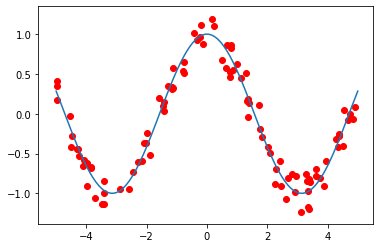

In [124]:
plt.plot(np.linspace(-5, 5, 100), np.cos(np.linspace(-5, 5, 100)))
plt.scatter(X, y, c='r')

## Классический GBM алгоритм

- набор данных $\large \left\{ (x_i, y_i) \right\}_{i=1, \ldots,n}$;
- число итераций $\large M$;
- выбор функции потерь $\large L(y, f)$ с выписанным градиентом;
- выбор семейства функций базовых алгоритмов $\large h(x, \theta)$, с процедурой их обучения;
- дополнительные гиперпараметры $\large h(x, \theta)$, например, глубина дерева у деревьев решений;

Единственный момент, который остался без внимания — начальное приближение $\large f_0(x)$. Для простоты, в качестве инициализации используют просто константное значение $\large \gamma$. Его, а также оптимальный коэффициент $\large \rho $ находят бинарным поиском, или другим line search алгоритмом относительно исходной функции потерь (а не градиента). Итак, GBM алгоритм:


1. Инициализировать GBM константным значением $\large \hat{f}(x) = \hat{f}_0, \hat{f}_0 = \gamma, \gamma \in \mathbb{R}$
$\large \hat{f}_0 = \underset{\gamma}{\arg\min} \ \sum_{i = 1}^{n} L(y_i, \gamma)$
2. Для каждой итерации $\large t = 1, \dots, M$ повторять:
   
    2.1 Посчитать псевдо-остатки $\large r_t$
    $\large r_{it} = -\left[\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}\right]_{f(x)=\hat{f}(x)}, \quad for i=1,\ldots,n$

    2.2 Построить новый базовый алгоритм $\large h_t(x)$ как регрессию на псевдо-остатках $\large \left\{ (x_i, r_{it}) \right\}_{i=1, \ldots,n}$
    
    2.3 Найти оптимальный коэффициент $\large \rho_t $ при $\large h_t(x)$ относительно исходной функции потерь
$\large \rho_t = \underset{\rho}{\arg\min} \ \sum_{i = 1}^{n} L(y_i, \hat{f}(x_i) + \rho \cdot h(x_i, \theta))$
    
    2.4 Сохранить $\large \hat{f_t}(x) = \rho_t \cdot h_t(x)$
    
    2.5 Обновить текущее приближение $\large \hat{f}(x)$
$\large \hat{f}(x) \leftarrow \hat{f}(x) + \hat{f_t}(x) = \sum_{i = 0}^{t} \hat{f_i}(x)$

1. Скомпоновать итоговую GBM модель $\large \hat{f}(x)$
$\large \hat{f}(x) = \sum_{i = 0}^M \hat{f_i}(x) $

## Пошаговый пример работы GBM

Игрушечные данные $\large \left\{ (x_i, y_i) \right\}_{i=1, \ldots,100}$ ✓

Число итераций $\large M = 3$ ✓;

Среднеквадратичная функция потерь $\large L(y, f) = (y-f)^2$ ✓

Градиент $\large L(y, f) = L_2$ loss это просто остатки $\large r = (y - f)$ ✓;

Деревья решений в качестве базовых алгоритмов $\large h(x)$ ✓;

Гиперпараметры деревьев решений: глубина деревьев равна 2 ✓;

У среднеквадратичной ошибки все просто и с инициализацией $\large \gamma$ и с коэффициентами $\large \rho_t$. А именно, инициализировать GBM мы будем средним значением $\large \gamma = \frac{1}{n} \cdot \sum_{i = 1}^n y_i$, а все $\large \rho_t$ равны 1.


In [125]:
from sklearn.tree import DecisionTreeRegressor

estimator = DecisionTreeRegressor(max_depth=2)
n_estimators = 100

In [126]:
gamma = np.sum(y) / len(y)
def f(x):
    return np.ones(len(y)) * gamma

estimators = [f]
rho = [1]
r = []

In [127]:
def gbm_predict(estimators, rho, x):
    y = estimators[0](x)
    for i in range(1, len(estimators)):
        y += rho[i] * estimators[i].predict(x)
    return y

In [129]:
for i in range(1, n_estimators):
    if i == 1:
        y_pred = estimators[0](X)
    else:
        y_pred = gbm_predict(estimators, rho, X.reshape(-1, 1))
    r_it = -2/len(y) * (y_pred - y)
    f_t = DecisionTreeRegressor(max_depth=2)
    f_t.fit(X.reshape(-1, 1), r_it)
    rho_t = 1
    estimators.append(f_t)
    rho.append(rho_t)
    r.append(r_it)

In [130]:
rho[0], estimators[1], len(rho), len(estimators)

(1,
 DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort=False, random_state=None, splitter='best'),
 101,
 101)

In [131]:
data = np.linspace(-5, 5, 100)
y_pred = gbm_predict(estimators, rho, data.reshape(-1, 1))

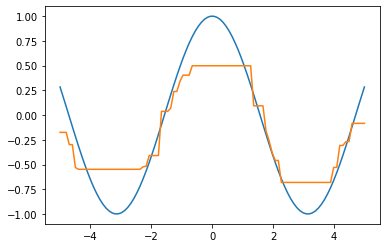

In [132]:
plt.plot(data, np.cos(data))
plt.plot(data, y_pred)

# Xgboost

Функция потерь дополнительно включает в себя члены регуляризации. Например, для дереьев - количство листьев и сумма весов модели в листьях
https://xgboost.readthedocs.io/en/stable/tutorials/model.html

### Сравнение Xgboost и градиентного бустинга Sklearn
https://github.com/Yorko/mlcourse.ai/blob/main/jupyter_russian/topic10_boosting/lesson10_part2_xgboost_scikit_gboost.ipynb

In [139]:
import time
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier

In [148]:
xgb_params1 = {
    "booster": "gbtree",
    "max_depth": 3,
    "eta": 0.1,
    "objective": "binary:logistic",
    "nthread": 1,
    "eval_metric": "logloss"
}
xgb_params2 = {
    "booster": "gbtree",
    "max_depth": 3,
    "eta": 0.1,
    "objective": "binary:logistic",
    "nthread": 4,
    "eval_metric": "logloss"
}
sklearn_params = {"n_estimators": 100, "max_depth": 3}

In [149]:
xgb_time1 = list()
xgb_time2 = list()
sklearn_time = list()

In [150]:
n_runs = 50

for i in range(n_runs):
    # Generating dataset
    X, y = make_classification(n_samples=1000, n_features=50, n_informative=20)
    # Training XGBooster (nthread=1)
    t = time.time()
    bst = xgb.train(xgb_params1, xgb.DMatrix(X, label=y), num_boost_round=100)
    elapsed = time.time() - t
    xgb_time1.append(elapsed)
    # Training XGBooster (nthread=4)
    t = time.time()
    bst = xgb.train(xgb_params2, xgb.DMatrix(X, label=y), num_boost_round=100)
    elapsed = time.time() - t
    xgb_time2.append(elapsed)
    # Training GradientBoostingClassifier
    t = time.time()
    clf = GradientBoostingClassifier(**sklearn_params).fit(X, y)
    elapsed = time.time() - t
    sklearn_time.append(elapsed)

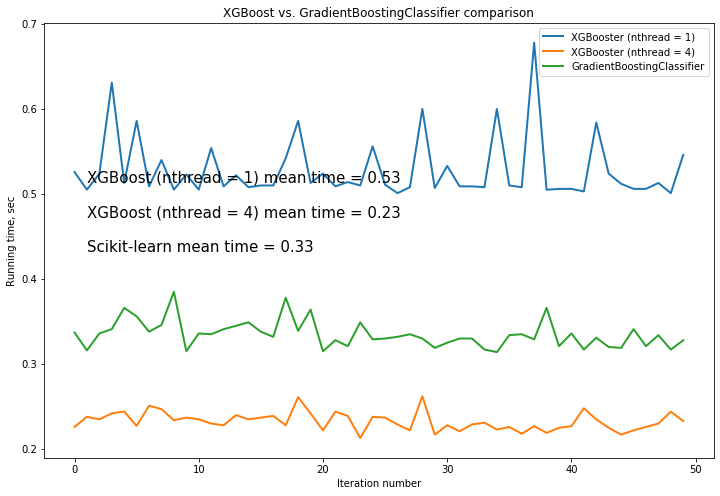

In [151]:
xgb_mean1 = sum(xgb_time1) / n_runs
xgb_mean2 = sum(xgb_time2) / n_runs
sklearn_mean = sum(sklearn_time) / n_runs

plt.figure(figsize=(12, 8))
plt.plot(xgb_time1, label="XGBooster (nthread = 1)", lw=2)
plt.plot(xgb_time2, label="XGBooster (nthread = 4)", lw=2)
plt.plot(sklearn_time, label="GradientBoostingClassifier", lw=2)
plt.legend(loc="best")
plt.text(
    1,
    (xgb_mean1 + sklearn_mean) / 2,
    "XGBoost (nthread = 1) mean time = %.2f" % xgb_mean1
    + "\n\nXGBoost (nthread = 4) mean time = %.2f" % xgb_mean2
    + "\n\nScikit-learn mean time = %.2f" % sklearn_mean,
    fontsize=15,
)
plt.xlabel("Iteration number")
plt.ylabel("Running time, sec")
plt.title("XGBoost vs. GradientBoostingClassifier comparison")
plt.show()

## AdaBoost

In [154]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [157]:
dt = DecisionTreeClassifier().fit(X_train, y_train)
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3)).fit(X_train, y_train)

print('Decision tree score: ', dt.score(X_test, y_test))
print('AdaBoost score: ', ada.score(X_test, y_test))

Decision tree score:  0.96
AdaBoost score:  0.98


## xgboost

In [164]:
from sklearn.model_selection import KFold
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error

In [165]:
boston = load_boston()
X = boston['data']
y = boston['target']

In [167]:
kf = KFold(n_splits=5, shuffle=True, random_state=17)

for train_index, test_index in kf.split(y):
    xgb_model = xgb.XGBRegressor().fit(X[train_index], y[train_index])
    y_pred = xgb_model.predict(X[test_index])
    print(mean_squared_error(y[test_index], y_pred))

9.047410100576514
8.691278284433457
15.02594228266038
7.3853090480194155
7.329729535123723
